In [110]:
from bs4 import BeautifulSoup
import requests as req
from time import sleep
import pandas as pd
import os
import time
from datetime import datetime as dt
from tqdm import tqdm
#from tqdm import tqdm


# configure pandas
#pd.set_option('display.max_rows', 500)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
        "(KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36"
    )
}

city_map = {'New Orleans': 'New Orleans Saints',
 'Carolina': 'Carolina Panthers',
 'San Francisco': 'San Francisco 49ers',
 'Cincinnati': 'Cincinnati Bengals',
 'Philadelphia': 'Philadelphia Eagles',
 'Indianapolis': 'Indianapolis Colts',
 'Miami': 'Miami Dolphins',
 'Baltimore': 'Baltimore Ravens',
 'Washington': 'Washington Commanders',
 'Kansas City': 'Kansas City Chiefs',
 'LA Chargers': 'Los Angeles Chargers',
 'Minnesota': 'Minnesota Vikings',
 'Tennessee': 'Tennessee Titans',
 'Tampa Bay': 'Tampa Bay Buccaneers',
 'Denver': 'Denver Broncos',
 'Cleveland': 'Cleveland Browns',
 'Detroit': 'Detroit Lions',
 'NY Giants': 'New York Giants',
 'New England': 'New England Patriots',
 'LA Rams': 'Los Angeles Rams',
 'Las Vegas': 'Las Vegas Raiders',
 'Green Bay': 'Green Bay Packers',
 'Chicago': 'Chicago Bears',
 'Seattle': 'Seattle Seahawks',
 'Dallas': 'Dallas Cowboys',
 'Pittsburgh': 'Pittsburgh Steelers',
 'Jacksonville': 'Jacksonville Jaguars',
 'Arizona': 'Arizona Cardinals',
 'NY Jets': 'New York Jets',
 'Atlanta': 'Atlanta Falcons',
'Buffalo': 'Buffalo Bills',
'Houston': 'Houston Texans'
}

## Rank Data
____

In [111]:
dates_w_week = {
    "2022-11-23":11,
    "2022-11-16":10,
    "2022-11-09":9,
    "2022-11-02":8,
    "2022-10-26":7,
    "2022-10-19":6,
    "2022-10-12":5,
    "2022-10-05":4,
    "2022-09-28":3,
}

url = "https://www.teamrankings.com/nfl/stats/"
page = req.get(url, headers=headers).text
soup = BeautifulSoup(page, "html.parser")
pbar = tqdm(["points-per-game", "giveaways-per-game", "takeaways-per-game", "qb-sacked-per-game", "passing-yards-per-game", "rushing-yards-per-game"])
pd_list = []
for _date, week in dates_w_week.items():
    for end_point in pbar:
        time.sleep(.25)
        url = f"https://www.teamrankings.com/nfl/stat/{end_point}?date={_date}"
        page = req.get(url, headers=headers).text
        soup = BeautifulSoup(page, "html.parser")
        table = soup.find("table")
        df = pd.read_html(str(table))[0].replace("--",0)
        df["asof"] = _date
        df["week"] = week
        df["url"] = end_point
        file_name = end_point.replace('/', '_').replace("-","_") + "_week" + str(week)
        pbar.set_description(end_point)
        pd_list.append(df)
    
full_file_path = f"rank_data.csv"
df = pd.concat(pd_list)
df.to_csv(full_file_path)
print(df.head())

rushing-yards-per-game: 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]


   Rank          Team  2022  Last 3  Last 1  Home  Away  2021        asof  week              url
0     1   Kansas City  30.0    25.7    30.0  24.8  35.2  29.4  2022-11-23    11  points-per-game
1     2       Buffalo  28.1    26.0    31.0  34.0  24.2  29.8  2022-11-23    11  points-per-game
2     3    Cincinnati  26.5    30.7    37.0  31.0  23.5  26.3  2022-11-23    11  points-per-game
3     4  Philadelphia  26.3    22.3    17.0  27.0  25.6  25.5  2022-11-23    11  points-per-game
4     5       Seattle  25.7    24.7    16.0  21.5  28.5  23.2  2022-11-23    11  points-per-game



### Spread and Game Data
___

In [112]:
url = f"https://www.sportsoddshistory.com/nfl-game-season/?y=2022"
page = req.get(url, headers=headers).text
soup = BeautifulSoup(page, "html.parser")
tables = soup.find_all("table", attrs={"class":"soh1"})
pd_list = []
for i, table in enumerate(tables[2:]):
    df = pd.read_html(str(table))
    df = df[0]
    df.columns = df.iloc[-2]
    df = df.iloc[:-2,: ]
    df["week"] = i + 1
    pd_list.append(df)
df = pd.concat(pd_list)
print(df.head())
df.to_csv("/nfl_weekly_betting_summary.csv")

   Day          Date Time (ET)  NaN             Favorite         Score  Spread  NaN             Underdog Over/Under Notes  week
0  Thu   Sep 8, 2022      8:20  NaN        Buffalo Bills       W 31-10  W -2.5    @     Los Angeles Rams       U 52   NaN     1
1  Sun  Sep 11, 2022      1:00  NaN   New Orleans Saints       W 27-26  L -5.5    @      Atlanta Falcons     O 43.5   NaN     1
2  Sun  Sep 11, 2022      1:00    @    Carolina Panthers       L 24-26  L -1.5  NaN     Cleveland Browns       O 42   NaN     1
3  Sun  Sep 11, 2022      1:00  NaN  San Francisco 49ers       L 10-19    L -6    @        Chicago Bears       U 38   NaN     1
4  Sun  Sep 11, 2022      1:00    @   Cincinnati Bengals  L 20-23 (OT)    L -7  NaN  Pittsburgh Steelers       U 44   NaN     1


### Data Munging
____

In [113]:
df_games = pd.read_csv("nfl_weekly_betting_summary.csv")
df_ranks = pd.read_csv("rank_data.csv")

In [114]:
df_ranks["_stat"] = df_ranks.url
df_ranks["Stat"] = df_ranks._stat.str.split("-").str.join(" ").str.title()
df_ranks["Stat"] = df_ranks.Stat.str.replace("Per Game", "Pg").str.replace("Opponent", "Opp")\
.str.replace("Offensive", "Off")\
.str.replace("Defensive", "Def")\
.str.replace("Touchdowns", "Td")\
.str.replace("Rushing", "Run")\
.str.replace("Passing", "Pass")\
.str.replace("Interceptions", "Int")
df_ranks["full_team_name"] = df_ranks.Team.map(city_map)
df_ranks["rank_key"] = df_ranks.full_team_name + df_ranks._stat + df_ranks.week.apply(str)

In [115]:
df_games["fav_pts"] = df_games.Score.str.split(" ", expand=True)[1].str.split("-", expand=True)[0]
df_games["dog_pts"] = df_games.Score.str.split(" ", expand=True)[1].str.split("-", expand=True)[1]
#df_fav = df_games[["Date", "Time (ET)", "Favorite", "Underdog", "Score", "week", "fav_pts"]].rename(columns={"Favorite":"Team", "fav_pts":"team_pts_scored", "Underdog":"Opp",})
df_games = df_games[df_games.week.gt(2)]
df_games.Date = pd.to_datetime(df_games.Date)

In [116]:
df_games["rank_key"] = df_games.Favorite + "points-per-game" + df_games.week.apply(str)
df_games["fav_pts_pg"] = df_games.rank_key.map(df_ranks.set_index("rank_key")["2022"].to_dict())

df_games["rank_key"] = df_games.Underdog + "points-per-game" + df_games.week.apply(str)
df_games["dog_pts_pg"] = df_games.rank_key.map(df_ranks.set_index("rank_key")["2022"].to_dict())

df_games["rank_key"] = df_games.Favorite + "giveaways-per-game" + df_games.week.apply(str)
df_games["fav_giveaways_pg"] = df_games.rank_key.map(df_ranks.set_index("rank_key")["2022"].to_dict())
 
df_games["rank_key"] = df_games.Favorite + "takeaways-per-game" + df_games.week.apply(str)
df_games["fav_takeaways_pg"] = df_games.rank_key.map(df_ranks.set_index("rank_key")["2022"].to_dict())

df_games["rank_key"] = df_games.Underdog + "giveaways-per-game" + df_games.week.apply(str)

In [117]:
df_games["dog_takeaways_pg"] = df_games.rank_key.map(df_ranks.set_index("rank_key")["2022"].to_dict())

df_games["rank_key"] = df_games.Underdog + "takeaways-per-game" + df_games.week.apply(str)
df_games["dog_giveaways_pg"] = df_games.rank_key.map(df_ranks.set_index("rank_key")["2022"].to_dict())

In [122]:
df_games.week.max()

8

In [119]:
df_games["score_diff"] = df_games.dog_pts_pg - df_games.fav_pts_pg

In [120]:
df_games = df_games[[
 'Date',
 'Favorite',
 'Underdog',
 'week',
 'Spread', 
 'Score',
 'fav_pts',
 'dog_pts',
 'rank_key',
 'fav_pts_pg',
 'dog_pts_pg',
 'fav_giveaways_pg',
 'fav_takeaways_pg',
 'dog_takeaways_pg',
 'dog_giveaways_pg',
 'score_diff',
]]

In [123]:
df_train = df_games[df_games.week.lt(7)]
df_test = df_games[df_games.week.eq(8)]

In [124]:
df_test

,Date,Favorite,Underdog,week,Spread,Score,fav_pts,dog_pts,rank_key,fav_pts_pg,dog_pts_pg,fav_giveaways_pg,fav_takeaways_pg,dog_takeaways_pg,dog_giveaways_pg,score_diff
108,2022-10-27,Tampa Bay Buccaneers,Baltimore Ravens,8,L -1.5,L 22-27,22,27,Baltimore Ravenstakeaways-per-game8,18.3,26.0,0.9,1.1,1.1,1.9,7.7
109,2022-10-30,Jacksonville Jaguars,Denver Broncos,8,L -2,L 17-21,17,21,Denver Broncostakeaways-per-game8,21.5,15.1,1.5,1.3,1.1,1.1,-6.4
110,2022-10-30,Atlanta Falcons,Carolina Panthers,8,L -4,W 37-34 (OT),37,34,Carolina Pantherstakeaways-per-game8,25.0,19.8,1.3,1.4,1.1,1.0,-5.2
111,2022-10-30,Dallas Cowboys,Chicago Bears,8,W -10,W 49-29,49,29,Chicago Bearstakeaways-per-game8,22.9,19.4,0.9,1.6,1.5,1.6,-3.5
112,2022-10-30,Miami Dolphins,Detroit Lions,8,W -3.5,W 31-27,31,27,Detroit Lionstakeaways-per-game8,22.3,24.7,1.3,0.9,1.6,0.9,2.4
113,2022-10-30,Minnesota Vikings,Arizona Cardinals,8,W -3.5,W 34-26,34,26,Arizona Cardinalstakeaways-per-game8,24.7,22.8,1.0,1.9,1.0,1.4,-1.9
114,2022-10-30,Las Vegas Raiders,New Orleans Saints,8,L -1.5,L 0-24,0,24,New Orleans Saintstakeaways-per-game8,23.3,24.9,0.9,0.6,2.0,0.9,1.6
115,2022-10-30,New England Patriots,New York Jets,8,W -2.5,W 22-17,22,17,New York Jetstakeaways-per-game8,22.1,22.0,2.0,2.0,1.5,1.5,-0.1
116,2022-10-30,Philadelphia Eagles,Pittsburgh Steelers,8,W -10.5,W 35-13,35,13,Pittsburgh Steelerstakeaways-per-game8,28.0,15.0,0.3,2.3,1.8,1.3,-13.0
117,2022-10-30,Tennessee Titans,Houston Texans,8,W -3.5,W 17-10,17,10,Houston Texanstakeaways-per-game8,18.9,16.6,1.3,1.6,1.0,1.4,-2.3


In [135]:
from sklearn.linear_model import LinearRegression

In [136]:
mod = LinearRegression()

In [137]:
mod.fit(
df_train[[
 'fav_pts_pg',
 'dog_pts_pg',
 'fav_giveaways_pg',
 'fav_takeaways_pg',
 'dog_takeaways_pg',
 'dog_giveaways_pg',                 
]],
    df_train["score_diff"]
       )

LinearRegression()

In [138]:
df_test["pred"] = mod.predict(df_test[[
 'fav_pts_pg',
 'dog_pts_pg',
 'fav_giveaways_pg',
 'fav_takeaways_pg',
 'dog_takeaways_pg',
 'dog_giveaways_pg',  
]])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
import abc
import pandas as pd
from typing import Optional, Any, Union, Mapping, Callable, Dict
from functools import lru_cache
import numpy as np


class Check(abc.ABC):
    """Base class for a Data Quality Check.
    By default this assumes all checks have
    a simple contract providing a default checkname and consume """

    _checkname = "DefaultCheck"
    _model = "NoModel"

    def __init__(
        self,
        raw_df: Optional[pd.DataFrame] = None,
        train_df: Optional[pd.DataFrame] = None,
        name: Optional[str] = None,
        **kwargs
    ):
        """For Simplicity, We assume every Check is run in the context
        of a checksuite. Since we might want to run """

        if name is not None:
            self._checkname = name
            if self._checkname == "DefaultCheck":
                raise NameError("checkname not set!")

        # create a scratch space for internal data in the check
        self._private: Mapping[str, Any] = dict()
        self._params: Dict[str, Any] = kwargs
        self._raw_df = raw_df
        if train_df is None:
            self._train_df = raw_df

    @property
    def raw_df(self) -> pd.DataFrame:
        return self._raw_df

    @raw_df.setter
    def raw_df(self, raw_df: pd.DataFrame) -> None:
        if self._raw_df is None:
            self._raw_df = raw_df
        else:
            raise ValueError("raw_df already set")

    @property
    def train_df(self) -> pd.DataFrame:
        return self._train_df

    @train_df.setter
    def train_df(self, train_df: pd.DataFrame) -> None:
        if self._train_df is None:
            self._train_df = train_df
        else:
            raise ValueError("train_df already set")

    @property
    def params(self) -> Dict[str, Any]:
        return self._params

    @params.setter
    def params(self, params: Dict[str, Any]) -> None:
        # settings in check class overide settings from suite
        self._params.update(params)

    @property
    def checkname(self) -> str:
        return self._checkname

    @property
    def test(self) -> bool:
        """
        - Basic test method, return a boolean result based on if the
        dataframe passes or fails the test
        - default check the percentage for failing obervations and compares
        that against a threshold default is .10
        """
        t = self.params.get("failure_threshold", 0.10)
        return self.failure_rate < t

    @property
    @abc.abstractmethod
    def diagnostics(self) -> pd.DataFrame:
        """ Append model data to a copy of the original dataframe
        for easy debugging"""
        raise NotImplementedError

    @property
    def dep(self) -> Union[pd.Series, pd.DataFrame]:
        """ convenient property to pull dependent variable """
        return self.raw_df[self.params.get("dep")]

    @property
    def ind(self) -> pd.Series:
        """ convenient property to pull independent variable """
        return self.raw_df[self.params.get("ind")]

    @property
    @lru_cache(1)
    def formula(self) -> Callable:
        """ train the model """
        ind = self.train_df[self.params.get("ind")]
        dep = self.train_df[self.params.get("dep")]
        return self._model().fit(ind, dep)

    @property
    @lru_cache(1)
    def predicted_df(self) -> pd.DataFrame:
        """ udpate the dataframe dependent variables with predicted values """
        df = self.raw_df
        df[self.params.get("dep")] = self.prediction
        return df

    @property
    @lru_cache(1)
    def prediction_diffs(self) -> pd.Series:
        """ calculate the difference between prediction and actual values """
        return abs(self.dep - self.prediction)

    @property
    @lru_cache(1)
    def prediction(self) -> np.ndarray:
        """ use trained model to predict values """
        return self.formula.predict(self.ind)

    def predict_point(self, points) -> float:
        """ take random set of points provided by the user as a parameter
        'points' in kwargsand use the model formula to predict a value"""
        return self.formula.predict(points)

    @property
    @lru_cache(1)
    def failing_data(self) -> pd.Series:
        """failing tests return true"""
        return self.prediction_diffs > self.params.get("threshold")

    @property
    @lru_cache(1)
    def failure_rate(self) -> int:
        return np.count_nonzero(self.failing_data) / len(self.failing_data)

    @property
    @lru_cache(1)
    def failing_df(self) -> pd.DataFrame:
        df = self.raw_df.copy()
        df["failing"] = self.failing_data
        return df

    @property
    @lru_cache(1)
    def clean_df(self) -> pd.DataFrame:
        df = self.raw_df.copy()
        df[self.params.get("dep")] = self.clean_data
        return df

    @property
    @lru_cache(1)
    def clean_data(self) -> np.ndarray:
        return np.where(self.failing_data, self.prediction, self.dep)

    @property
    @lru_cache(1)
    def performance(self) -> int:
        """evaluates the performance of the model """

        ind = self.train_df[self.params.get("ind")]
        dep = self.train_df[self.params.get("dep")]
        mod = self.formula
        return mod.score(ind, dep)

## Backup Data
___

In [18]:
df_fav

,Date,Time (ET),Team,Opp,Score,week,team_pts_scored
0,"Sep 8, 2022",8:20,Buffalo Bills,Los Angeles Rams,W 31-10,1,31
1,"Sep 11, 2022",1:00,New Orleans Saints,Atlanta Falcons,W 27-26,1,27
2,"Sep 11, 2022",1:00,Carolina Panthers,Cleveland Browns,L 24-26,1,24
3,"Sep 11, 2022",1:00,San Francisco 49ers,Chicago Bears,L 10-19,1,10
4,"Sep 11, 2022",1:00,Cincinnati Bengals,Pittsburgh Steelers,L 20-23 (OT),1,20
...,...,...,...,...,...,...,...
118,"Oct 30, 2022",4:04,Seattle Seahawks,New York Giants,W 27-13,8,27
119,"Oct 30, 2022",4:25,Indianapolis Colts,Washington Commanders,L 16-17,8,16
120,"Oct 30, 2022",4:25,Los Angeles Rams,San Francisco 49ers,L 14-31,8,14
121,"Oct 30, 2022",8:20,Buffalo Bills,Green Bay Packers,W 27-17,8,27


In [7]:
df_opp = df_games[["Date", "Time (ET)", "Favorite", "Underdog", "Score", "week", "dog_pts"]].rename(columns={"Underdog":"Team", 
                                                                                                 "dog_pts":"team_pts_scored",
                                                                                                 "Favorite":"Opp"
                                                                                                })
df_games = pd.concat([df_fav, df_opp])
df_games = df_games[df_games.week.gt(2)]


In [8]:
df_games["rank_key"] = df_games.Team + "points-per-game" + df_games.week.apply(str)
df_games["team_points_pg"] = df_games.rank_key.map(df_ranks.set_index("rank_key")["2022"].to_dict())

df_games["rank_key"] = df_games.Opp + "points-per-game" + df_games.week.apply(str)
df_games["opp_points_pg"] = df_games.rank_key.map(df_ranks.set_index("rank_key")["2022"].to_dict())

df_games["rank_key"] = df_games.Team + "giveaways-per-game" + df_games.week.apply(str)
df_games["giveaways_pg"] = df_games.rank_key.map(df_ranks.set_index("rank_key")["2022"].to_dict())

df_games["rank_key"] = df_games.Team + "takeaways-per-game" + df_games.week.apply(str)
df_games["giveaways_pg"] = df_games.rank_key.map(df_ranks.set_index("rank_key")["2022"].to_dict())

df_games["rank_key"] = df_games.Opp + "giveaways-per-game" + df_games.week.apply(str)
df_games["takeaways_pg"] = df_games.rank_key.map(df_ranks.set_index("rank_key")["2022"].to_dict())

df_games["rank_key"] = df_games.Opp + "takeaways-per-game" + df_games.week.apply(str)
df_games["giveaways_pg"] = df_games.rank_key.map(df_ranks.set_index("rank_key")["2022"].to_dict())


In [9]:
df_games

,Date,Time (ET),Team,Opp,Score,week,team_pts_scored,rank_key,team_points_pg,opp_points_pg,giveaways_pg,takeaways_pg
32,"Sep 22, 2022",8:15,Cleveland Browns,Pittsburgh Steelers,W 29-17,3,29,Pittsburgh Steelerstakeaways-per-game3,28.3,18.0,2.0,1.0
33,"Sep 25, 2022",1:00,New Orleans Saints,Carolina Panthers,L 14-22,3,14,Carolina Pantherstakeaways-per-game3,17.0,20.7,1.0,1.0
34,"Sep 25, 2022",1:00,Chicago Bears,Houston Texans,W 23-20,3,23,Houston Texanstakeaways-per-game3,17.3,NaN,NaN,NaN
35,"Sep 25, 2022",1:00,Kansas City Chiefs,Indianapolis Colts,L 17-20,3,17,Indianapolis Coltstakeaways-per-game3,29.3,13.3,1.0,2.0
36,"Sep 25, 2022",1:00,Buffalo Bills,Miami Dolphins,L 19-21,3,19,Miami Dolphinstakeaways-per-game3,30.3,27.7,1.3,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...
118,"Oct 30, 2022",4:04,New York Giants,Seattle Seahawks,W 27-13,8,13,Seattle Seahawkstakeaways-per-game8,20.4,26.3,1.8,1.4
119,"Oct 30, 2022",4:25,Washington Commanders,Indianapolis Colts,L 16-17,8,17,Indianapolis Coltstakeaways-per-game8,17.8,16.1,1.0,2.0
120,"Oct 30, 2022",4:25,San Francisco 49ers,Los Angeles Rams,L 14-31,8,31,Los Angeles Ramstakeaways-per-game8,22.0,16.9,1.1,1.9
121,"Oct 30, 2022",8:20,Green Bay Packers,Buffalo Bills,W 27-17,8,17,Buffalo Billstakeaways-per-game8,18.1,29.0,2.0,1.7


<AxesSubplot:xlabel='Date'>

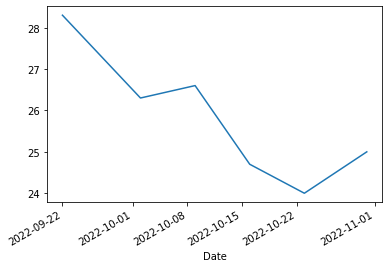

In [11]:
#from matplotlib import pyplot as plt
 
df_games.Date = pd.to_datetime(df_games.Date)
df_games[df_games.Team.eq("Cleveland Browns")].set_index("Date")["team_points_pg"].plot()
